### **1. 라이브러리 설치 및 GPU 연결**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# GPU 연결
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


###**2. 데이터 불러오기**

In [3]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 473kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.79MB/s]


In [4]:
# 한 배치 꺼내기
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print("입력 이미지 모양:", example_data.shape)
print("정답 라벨:", example_targets[:10])  # 앞 10개만 출력

입력 이미지 모양: torch.Size([1000, 1, 28, 28])
정답 라벨: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


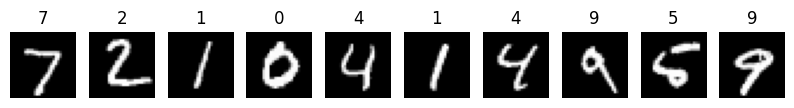

In [5]:
# 앞에서 가져온 example_data로 이미지 출력
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')  # [0]은 채널 추출
    plt.title(str(example_targets[i].item()))
    plt.axis('off')
plt.show()

###**3. CNN 모델**

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

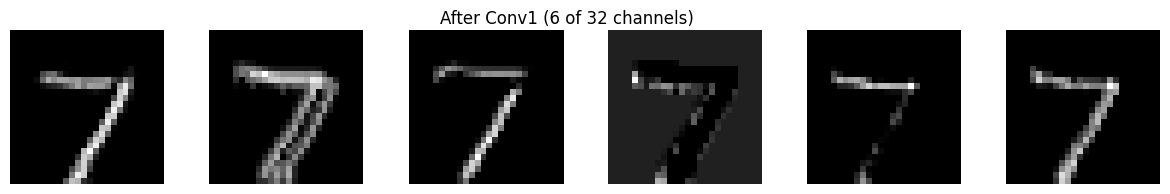

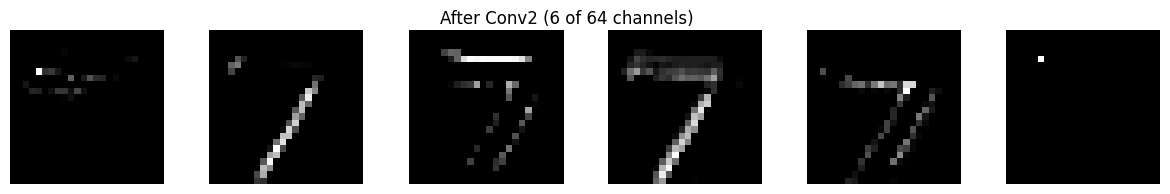

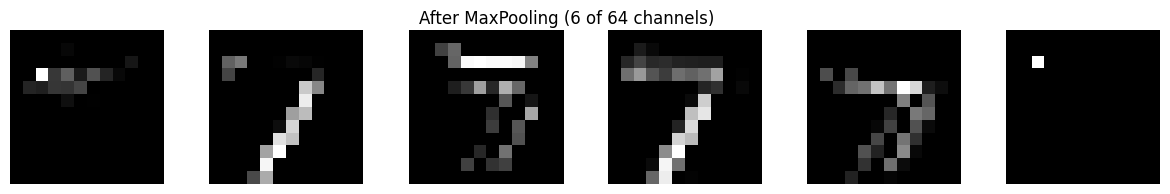

In [7]:
# 모델에서 중간 결과를 보기 위해 일부만 분리
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.conv1 = model.conv1
        self.conv2 = model.conv2

    def forward(self, x):
        x = F.relu(self.conv1(x))     # conv1 출력
        out1 = x.detach().cpu()       # 저장용
        x = F.relu(self.conv2(x))     # conv2 출력
        out2 = x.detach().cpu()
        x = F.max_pool2d(x, 2)        # pooling 후
        out3 = x.detach().cpu()
        return out1, out2, out3

# 모델 연결
extractor = FeatureExtractor(model).to(device)

# 테스트 이미지 하나 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[0].unsqueeze(0).to(device)  # 배치 차원 추가

# 특징 추출
feat1, feat2, feat3 = extractor(img)

# 시각화 함수
def plot_features(features, title, num_channels=6):
    plt.figure(figsize=(15, 2))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i+1)
        plt.imshow(features[0, i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 그리기
plot_features(feat1, "After Conv1 (6 of 32 channels)")
plot_features(feat2, "After Conv2 (6 of 64 channels)")
plot_features(feat3, "After MaxPooling (6 of 64 channels)")


###**4. 모델 학습**

In [8]:
model = SimpleCNN().to(device) #모델 초기화

In [9]:
train_losses = []       # 손실 저장 리스트
test_accuracies = []    # 정확도 저장 리스트 추가

def train(model, train_loader, epochs=4):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 정확도 측정 및 저장
        acc = test_accuracy(model, test_loader)
        test_accuracies.append(acc)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

def test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += len(data)
    acc = 100 * correct / total
    return acc

train(model, train_loader)

Epoch 1, Loss: 0.1447, Accuracy: 98.38%
Epoch 2, Loss: 0.0413, Accuracy: 98.60%
Epoch 3, Loss: 0.0270, Accuracy: 98.75%
Epoch 4, Loss: 0.0174, Accuracy: 98.70%


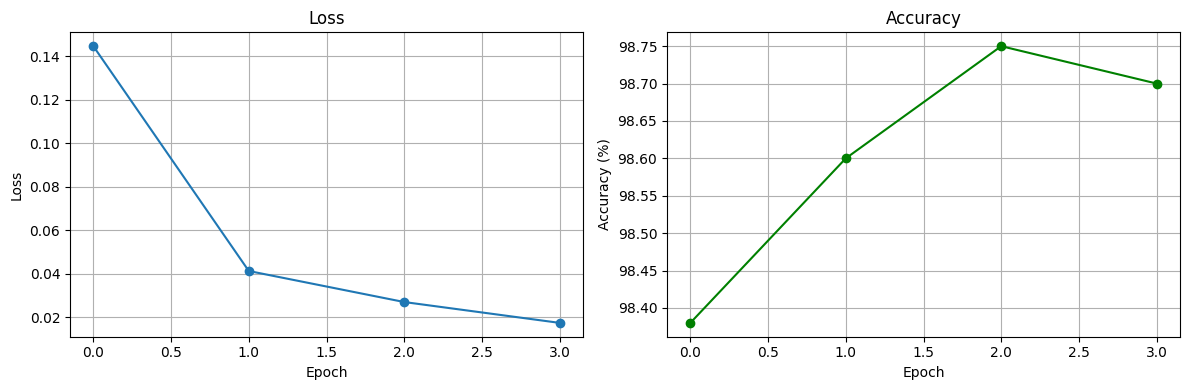

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, marker='o', color='green')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

###**5. FGSM (untargeted) 구현**

In [11]:
def fgsm_targeted(model, x, target, eps):
    x_adv = x.clone().detach().to(device)
    x_adv.requires_grad = True

    output = model(x_adv)
    loss = F.cross_entropy(output, target.to(device))  # target 기준

    model.zero_grad()
    loss.backward()

    grad_sign = x_adv.grad.data.sign()
    x_adv = x_adv - eps * grad_sign  # 부호 반대
    x_adv = torch.clamp(x_adv, 0, 1)

    return x_adv.detach()

In [19]:
import random

# test dataset에서 무작위 인덱스 하나 고르기
rand_idx = random.randint(0, len(test_dataset) - 1)

# 해당 인덱스의 이미지와 정답 레이블 가져오기
x, label = test_dataset[rand_idx]
x = x.unsqueeze(0).to(device)
label = torch.tensor([label]).to(device)

# print(f"index: {rand_idx}")
print(f"label: {label.item()}")

label: 4


In [20]:
# 정답이 아닌 다른 숫자 중 하나를 target으로 고르기
all_classes = list(range(10))
all_classes.remove(label.item())  # 정답 빼기
target_class = random.choice(all_classes)  # 다른 숫자 중 랜덤 선택

target = torch.tensor([target_class]).to(device)

print(f"target class: {target.item()}")

target class: 5


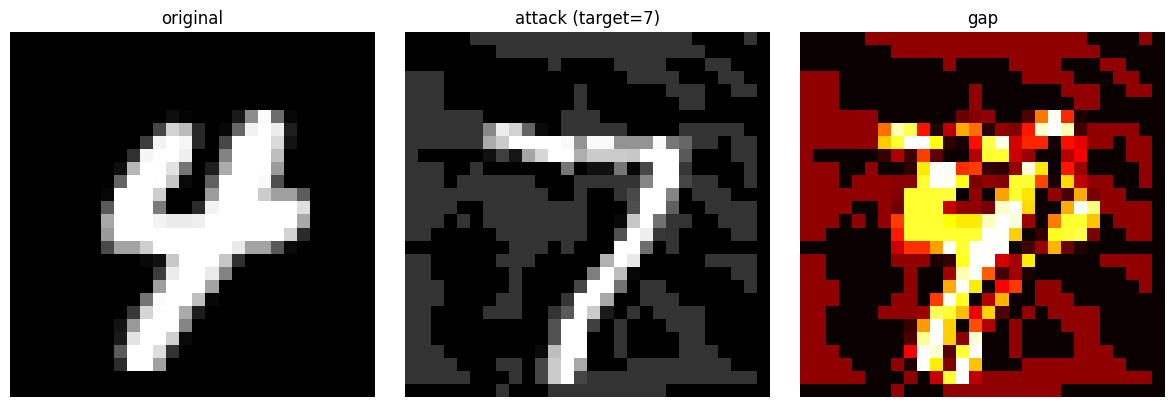

In [21]:
import matplotlib.pyplot as plt

# CPU로 옮기고 차원 제거
orig = x.detach().cpu().squeeze()
adv = x_adv.detach().cpu().squeeze()
diff = (adv - orig).abs()

plt.figure(figsize=(12, 4))

# 원본
plt.subplot(1, 3, 1)
plt.imshow(orig, cmap='gray')
plt.title("original")
plt.axis('off')

# 공격 이미지
plt.subplot(1, 3, 2)
plt.imshow(adv, cmap='gray')
plt.title("attack (target=7)")
plt.axis('off')

# 차이 (노이즈)
plt.subplot(1, 3, 3)
plt.imshow(diff, cmap='hot')
plt.title("gap")
plt.axis('off')

plt.tight_layout()
plt.show()

In [22]:
model.eval()
pred_before = model(x).argmax(dim=1).item()
pred_after = model(x_adv).argmax(dim=1).item()

print(f"공격 전 예측: {pred_before}")
print(f"공격 후 예측: {pred_after}")

공격 전 예측: 4
공격 후 예측: 7


In [27]:
import random
import matplotlib.pyplot as plt

def visualize_multiple_targeted_attacks(model, dataset, num_samples=5, eps=0.3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(12, 3 * num_samples))

    for i, idx in enumerate(indices):
        x, label = dataset[idx]
        x = x.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        # 정답이 아닌 랜덤 target 클래스 선택
        all_classes = list(range(10))
        all_classes.remove(label.item())
        target_class = random.choice(all_classes)
        target = torch.tensor([target_class]).to(device)

        # 공격 수행
        x_adv = fgsm_targeted(model, x, target, eps)

        # 모델 예측
        pred_before = model(x).argmax(dim=1).item()
        pred_after = model(x_adv).argmax(dim=1).item()

        # 이미지 준비
        orig = x.detach().cpu().squeeze()
        adv = x_adv.detach().cpu().squeeze()
        diff = (adv - orig).abs()

        # 시각화
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(orig, cmap='gray')
        plt.title(f"original (label: {label.item()})\npredict: {pred_before}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(adv, cmap='gray')
        plt.title(f"attack (target: {target_class})\npredict: {pred_after}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(diff, cmap='hot')
        plt.title("gap")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

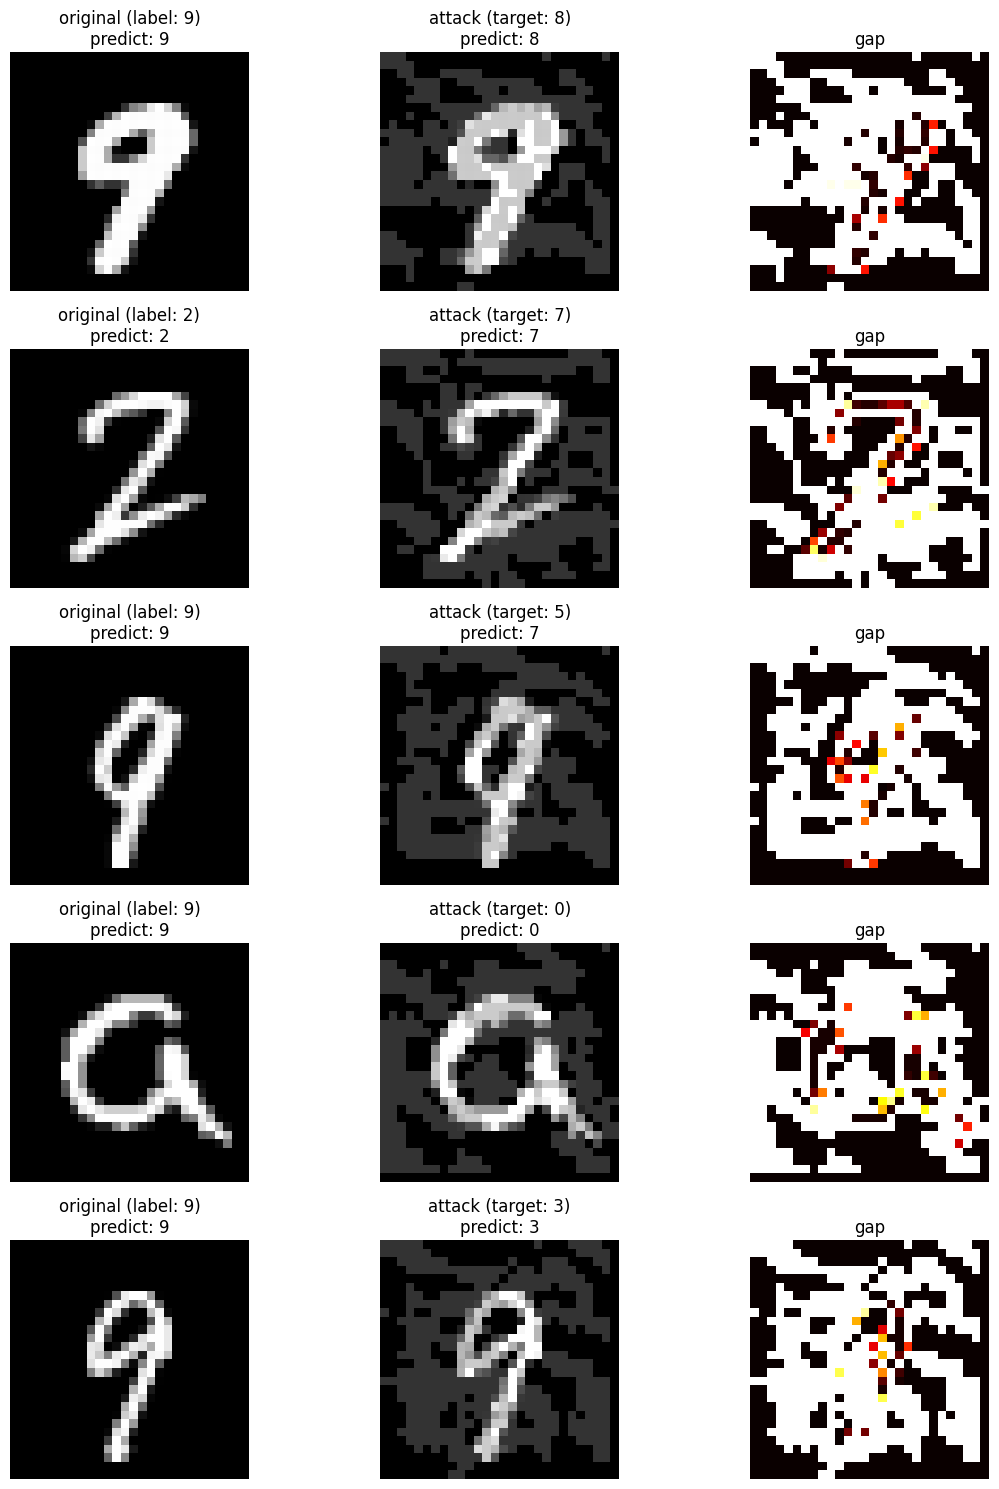

In [30]:
visualize_multiple_targeted_attacks(model, test_dataset, num_samples=5, eps=0.2)

###**6. 테스트 함수: 공격 전후 정확도 비교**

In [32]:
def test_targeted_fgsm(model, test_loader, eps=0.2, fixed_target=None):
    model.eval()
    total = 0
    correct_clean = 0
    successful_attack = 0

    for data, label in test_loader:
        data, label = data.to(device), label.to(device)

        # target 클래스 설정: 고정 or 랜덤
        if fixed_target is not None:
            target = torch.full_like(label, fixed_target).to(device)
        else:
            target = torch.randint(0, 10, label.shape).to(device)
            mask = target == label
            while mask.any():  # target이 정답이랑 겹치는 경우 다시 샘플링
                target[mask] = torch.randint(0, 10, (mask.sum(),)).to(device)
                mask = target == label

        # 원본 예측
        output_clean = model(data)
        pred_clean = output_clean.argmax(dim=1)
        correct_clean += pred_clean.eq(label).sum().item()

        # Targeted FGSM 공격
        data_adv = fgsm_targeted(model, data, target, eps)

        # 공격 이미지 예측
        output_adv = model(data_adv)
        pred_adv = output_adv.argmax(dim=1)

        # 공격이 성공했는가? → pred_adv == target
        successful_attack += pred_adv.eq(target).sum().item()
        total += len(data)

    clean_acc = 100 * correct_clean / total
    attack_success_rate = 100 * successful_attack / total

    print(f"Clean Accuracy: {clean_acc:.2f}%")
    print(f"Targeted Attack Success Rate (eps={eps}): {attack_success_rate:.2f}%")

In [33]:
# 랜덤 target class로 공격
test_targeted_fgsm(model, test_loader, eps=0.2)

# 또는: 모든 이미지를 7로 속이고 싶은 경우
test_targeted_fgsm(model, test_loader, eps=0.2, fixed_target=7)

Clean Accuracy: 98.70%
Targeted Attack Success Rate (eps=0.2): 18.73%
Clean Accuracy: 98.70%
Targeted Attack Success Rate (eps=0.2): 28.14%


In [34]:
def get_targeted_attack_success_rate(model, test_loader, eps, fixed_target=None):
    model.eval()
    total = 0
    successful_attack = 0

    for data, label in test_loader:
        data, label = data.to(device), label.to(device)

        # Target 지정
        if fixed_target is not None:
            target = torch.full_like(label, fixed_target).to(device)
        else:
            target = torch.randint(0, 10, label.shape).to(device)
            mask = target == label
            while mask.any():
                target[mask] = torch.randint(0, 10, (mask.sum(),)).to(device)
                mask = target == label

        # FGSM 공격
        data_adv = fgsm_targeted(model, data, target, eps)
        output_adv = model(data_adv)
        pred_adv = output_adv.argmax(dim=1)

        # 성공한 공격 수
        successful_attack += pred_adv.eq(target).sum().item()
        total += len(data)

    success_rate = 100 * successful_attack / total
    return success_rate

Testing eps=0.00...
Testing eps=0.03...
Testing eps=0.07...
Testing eps=0.10...
Testing eps=0.13...
Testing eps=0.17...
Testing eps=0.20...
Testing eps=0.23...
Testing eps=0.27...
Testing eps=0.30...


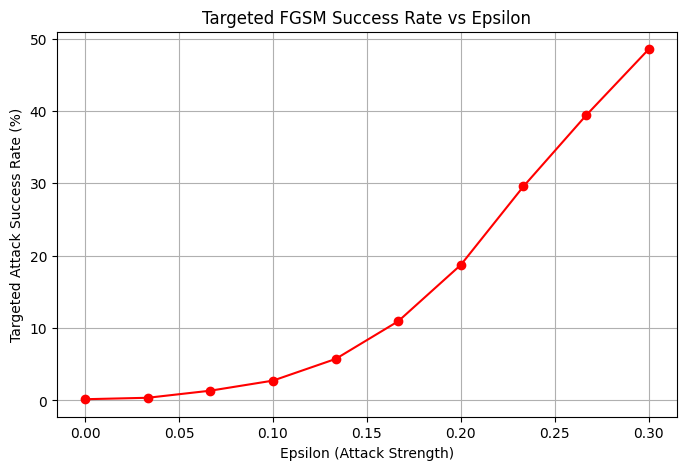

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 실험할 epsilon 값들
epsilons = np.linspace(0, 0.3, 10)
success_rates = []

for eps in epsilons:
    print(f"Testing eps={eps:.2f}...")
    rate = get_targeted_attack_success_rate(model, test_loader, eps)
    success_rates.append(rate)

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(epsilons, success_rates, marker='o', linestyle='-', color='red')
plt.title("Targeted FGSM Success Rate vs Epsilon")
plt.xlabel("Epsilon (Attack Strength)")
plt.ylabel("Targeted Attack Success Rate (%)")
plt.grid(True)
plt.show()

In [36]:
# target별 eps에 따른 성공률
import numpy as np
import matplotlib.pyplot as plt

def success_rate_per_target_per_eps(model, test_loader, epsilons):
    model.eval()
    num_classes = 10
    results = {target: [] for target in range(num_classes)}

    for target_class in range(num_classes):
        print(f"Target Class {target_class}:")
        for eps in epsilons:
            total = 0
            successful = 0

            for data, label in test_loader:
                data, label = data.to(device), label.to(device)

                # 정답과 같은 target 제외
                mask = label != target_class
                if mask.sum() == 0:
                    continue
                data = data[mask]
                label = label[mask]
                target = torch.full_like(label, target_class)

                # 공격
                data_adv = fgsm_targeted(model, data, target, eps)
                output_adv = model(data_adv)
                pred_adv = output_adv.argmax(dim=1)

                successful += pred_adv.eq(target.to(device)).sum().item()
                total += len(data)

            rate = 100 * successful / total if total > 0 else 0
            results[target_class].append(rate)
            print(f"  eps={eps:.2f} → success={rate:.2f}%")

    return results

Target Class 0:
  eps=0.00 → success=0.09%
  eps=0.03 → success=0.20%
  eps=0.07 → success=0.50%
  eps=0.10 → success=0.96%
  eps=0.13 → success=1.94%
  eps=0.17 → success=3.60%
  eps=0.20 → success=6.18%
  eps=0.23 → success=9.40%
  eps=0.27 → success=12.83%
  eps=0.30 → success=16.43%
Target Class 1:
  eps=0.00 → success=0.23%
  eps=0.03 → success=0.39%
  eps=0.07 → success=1.06%
  eps=0.10 → success=2.41%
  eps=0.13 → success=4.61%
  eps=0.17 → success=9.10%
  eps=0.20 → success=16.28%
  eps=0.23 → success=25.27%
  eps=0.27 → success=35.00%
  eps=0.30 → success=42.29%
Target Class 2:
  eps=0.00 → success=0.09%
  eps=0.03 → success=0.33%
  eps=0.07 → success=0.80%
  eps=0.10 → success=1.97%
  eps=0.13 → success=5.16%
  eps=0.17 → success=12.49%
  eps=0.20 → success=24.99%
  eps=0.23 → success=43.24%
  eps=0.27 → success=59.92%
  eps=0.30 → success=73.27%
Target Class 3:
  eps=0.00 → success=0.20%
  eps=0.03 → success=0.67%
  eps=0.07 → success=2.11%
  eps=0.10 → success=5.52%
  eps=0

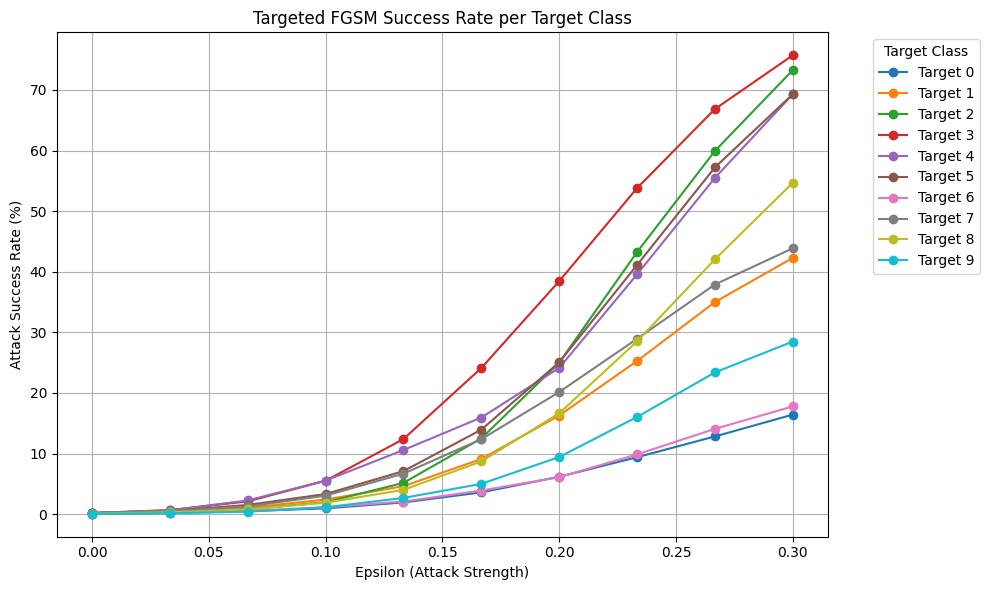

In [37]:
# 실험용 epsilon 리스트
epsilons = np.linspace(0, 0.3, 10)
results = success_rate_per_target_per_eps(model, test_loader, epsilons)

# 시각화
plt.figure(figsize=(10, 6))
for target_class, rates in results.items():
    plt.plot(epsilons, rates, marker='o', label=f'Target {target_class}')

plt.xlabel("Epsilon (Attack Strength)")
plt.ylabel("Attack Success Rate (%)")
plt.title("Targeted FGSM Success Rate per Target Class")
plt.grid(True)
plt.legend(title="Target Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [40]:
# 원래 label별 target 마다 성공률을 히트맵으로
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def targeted_success_matrix(model, test_loader, eps):
    model.eval()
    num_classes = 10
    matrix = np.zeros((num_classes, num_classes))

    for true_class in range(num_classes):
        for target_class in range(num_classes):
            if target_class == true_class:
                matrix[true_class][target_class] = np.nan
                continue

            total = 0
            success = 0

            for data, label in test_loader:
                data, label = data.to(device), label.to(device)
                mask = label == true_class
                if mask.sum() == 0:
                    continue

                data = data[mask]
                target = torch.full_like(label[mask], target_class).to(device)

                data_adv = fgsm_targeted(model, data, target, eps)
                output_adv = model(data_adv)
                pred_adv = output_adv.argmax(dim=1)

                success += pred_adv.eq(target).sum().item()
                total += len(data)

            matrix[true_class][target_class] = 100 * success / total if total > 0 else 0

    return matrix

Calculating matrix for eps=0.1...
Calculating matrix for eps=0.2...
Calculating matrix for eps=0.3...
Calculating matrix for eps=0.4...


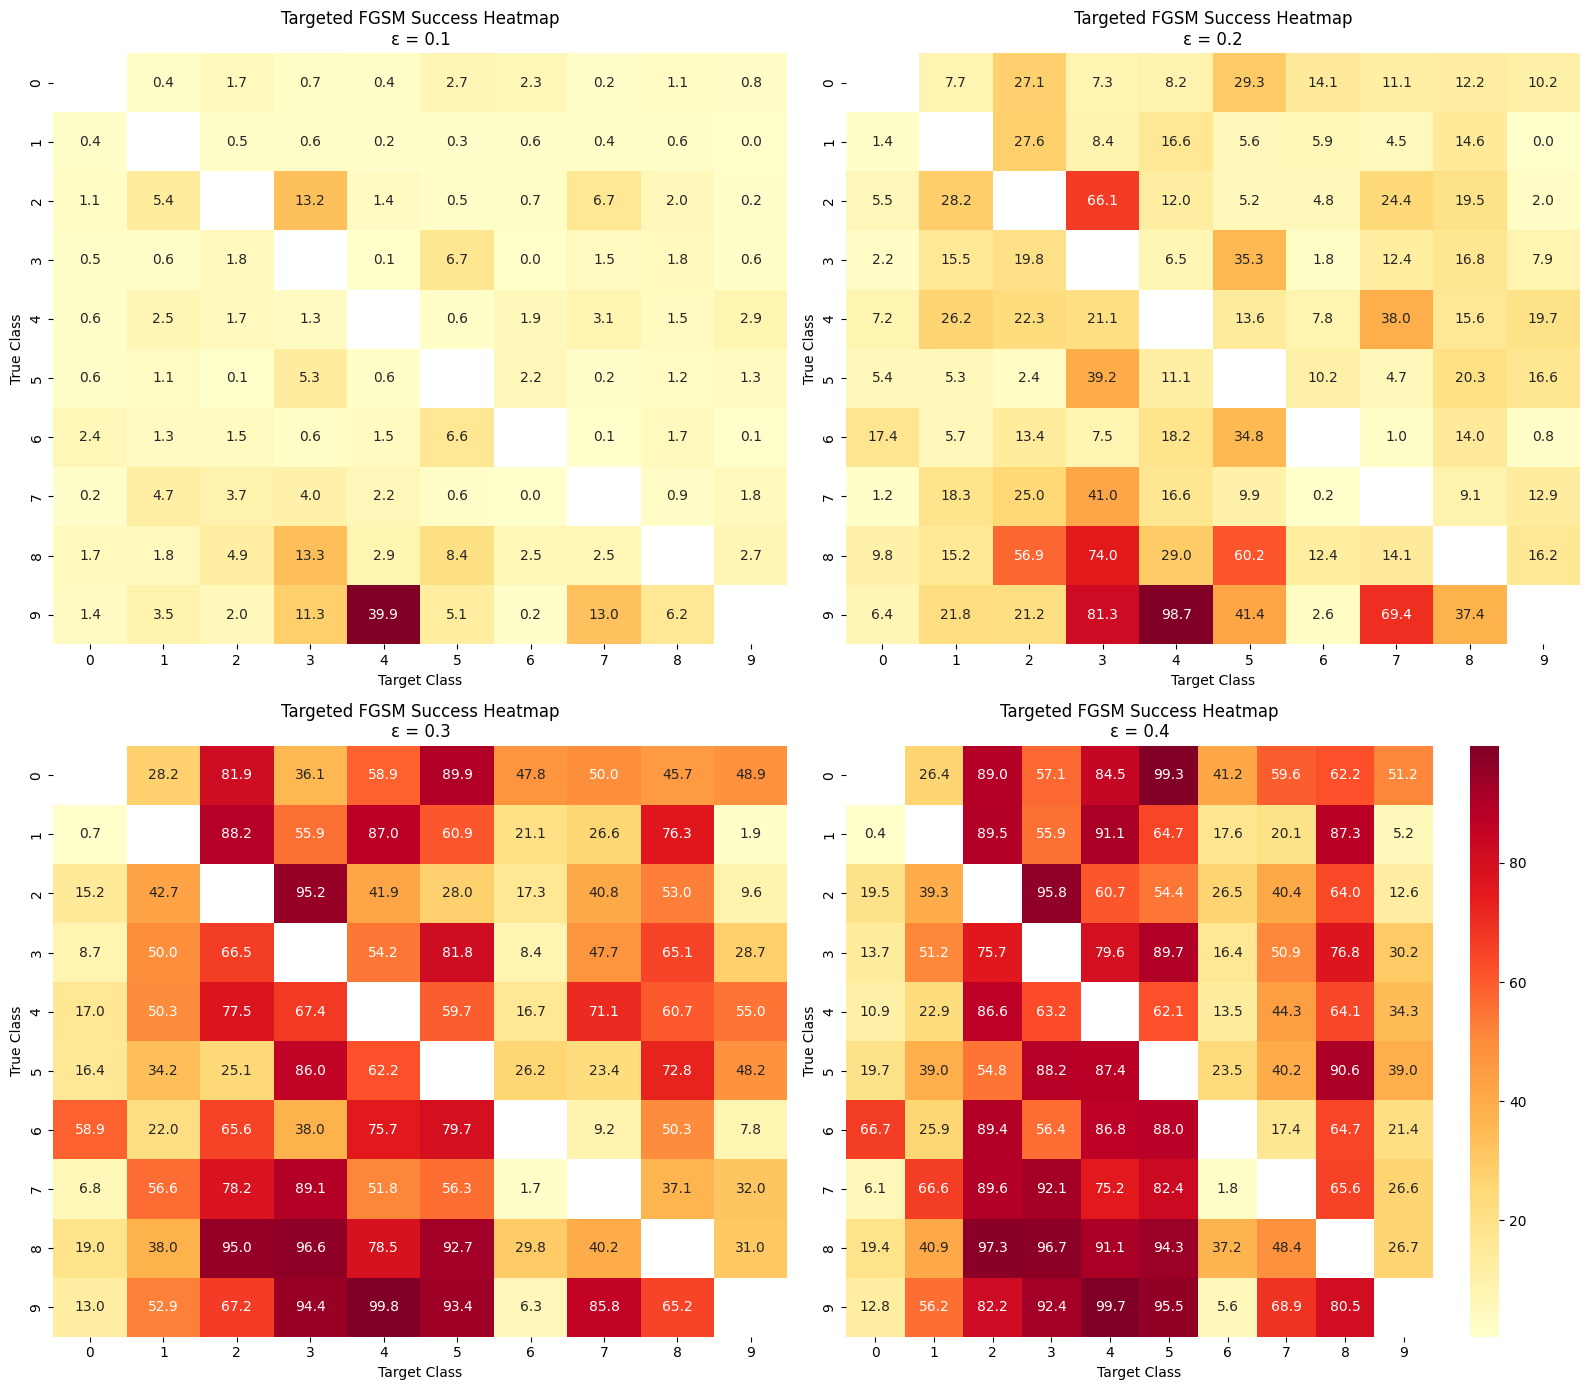

In [41]:
epsilons = [0.1, 0.2, 0.3, 0.4]
matrices = []

# 각 eps에 대해 매트릭스 생성
for eps in epsilons:
    print(f"Calculating matrix for eps={eps}...")
    matrix = targeted_success_matrix(model, test_loader, eps)
    matrices.append(matrix)

# 히트맵 시각화 (2x2 레이아웃)
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for i, ax in enumerate(axes.flat):
    sns.heatmap(matrices[i], ax=ax, annot=True, fmt=".1f", cmap="YlOrRd",
                xticklabels=range(10), yticklabels=range(10),
                cbar=i==3)  # 마지막만 colorbar 표시
    ax.set_title(f"Targeted FGSM Success Heatmap\nε = {epsilons[i]}")
    ax.set_xlabel("Target Class")
    ax.set_ylabel("True Class")

plt.tight_layout()
plt.show()


##**7. 인사이트**

- target마다 편차가 꽤 있다.
- 2, 3, 4, 5로 target하는 것은 성공률이 높은 편이고, 0, 9, 6으로 target하는 것은 성공률이 낮은 편이다.
- 문자의 특징적인 모습이 클수록 성공하기 쉬운 것 같다.
- targeted attack은 비가역적(비대칭적)이다. 예를들어, 9를 4로 attack은 쉬우나, 4를 9로 바꾸는건 쉽지 않다.